In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import os

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Resize((48,48)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

dataset=ImageFolder("Emotions/train",transform=transform)


In [78]:

# Collecting the images of a type and shuffling them

from collections import defaultdict
import random

class_indices=defaultdict(list)

for index,label in enumerate(dataset.targets):
    class_indices[label].append(index)

for label,index in enumerate(class_indices):
    random.shuffle(class_indices[label])


In [79]:
# Selecting small subsets
reduced_indices={}
for label,index in enumerate(class_indices):
    subset_count=int(len(class_indices[label]))
    reduced_indices[label]=class_indices[label][:subset_count]
reduced_indices

# Flattening out the indices into one list
import itertools
final_indices=list(itertools.chain.from_iterable(reduced_indices.values()))


In [80]:
# Creating a Subset of the indices
from torch.utils.data import Subset
subset_dataset=Subset(dataset,final_indices)

# Loading the data
from torch.utils.data import DataLoader
train_loader=DataLoader(subset_dataset,batch_size=32,shuffle=True)



In [81]:
import torch.nn as nn

class EmotionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
        self.maxpool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.relu=nn.ReLU()
        self.batchnorm1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm2=nn.BatchNorm2d(64)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.batchnorm3=nn.BatchNorm2d(128)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm4=nn.BatchNorm2d(256)
        self.linear1=nn.Linear(in_features=2304,out_features=512)
        self.dropout=nn.Dropout(0.5)
        self.linear2=nn.Linear(in_features=512,out_features=7)
        
    def forward(self,x):
        y=self.conv1(x)
        y=self.batchnorm1(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=self.conv2(y)
        y=self.batchnorm2(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=self.conv3(y)
        y=self.batchnorm3(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=self.conv4(y)
        y=self.batchnorm4(y)
        y=self.relu(y)
        y=self.maxpool(y)
        y=torch.flatten(y,1)
        y=self.linear1(y)
        y=self.relu(y)
        y=self.dropout(y)
        y=self.linear2(y)

        return y
    

        


In [71]:
CNN=EmotionCNN().to("mps")
criterion=nn.CrossEntropyLoss()
optim=torch.optim.Adam(CNN.parameters(),lr=0.001)



In [82]:
import tqdm

num_epochs=20

for i in tqdm.tqdm(range(num_epochs)):
    CNN.train()
    running_loss=0
    correct_predictions=0
    for images,label in train_loader:
        images,label=images.to('mps'),label.to('mps')
        optim.zero_grad()
        output=CNN(images)
        loss=criterion(output,label)
        loss.backward()
        optim.step()
        running_loss+=loss.item()
        preds=torch.argmax(output,dim=1)
        correct_predictions += (preds == label).sum().item()

    avg_train_loss=running_loss/len(train_loader)
    total_samples = len(train_loader.dataset)

    train_accuracy=correct_predictions/total_samples
    print(f'Average Training Loss in epoch{i+1} = {avg_train_loss}')
    print(f'Average Training Accuracy in epoch{i+1} = {train_accuracy}')


  5%|▌         | 1/20 [00:30<09:38, 30.44s/it]

Average Training Loss in epoch1 = 1.4965003410930888
Average Training Accuracy in epoch1 = 0.4288898951548295


 10%|█         | 2/20 [00:56<08:26, 28.12s/it]

Average Training Loss in epoch2 = 1.2624694791960558
Average Training Accuracy in epoch2 = 0.5196628235048243


 15%|█▌        | 3/20 [01:27<08:13, 29.05s/it]

Average Training Loss in epoch3 = 1.1428063119572893
Average Training Accuracy in epoch3 = 0.5631683444216099


 20%|██        | 4/20 [01:50<07:12, 27.00s/it]

Average Training Loss in epoch4 = 1.0490735091584298
Average Training Accuracy in epoch4 = 0.6015186875195931


 25%|██▌       | 5/20 [02:13<06:21, 25.47s/it]

Average Training Loss in epoch5 = 0.941070830835266
Average Training Accuracy in epoch5 = 0.6447107178933436


 30%|███       | 6/20 [02:39<05:59, 25.69s/it]

Average Training Loss in epoch6 = 0.8333181459747072
Average Training Accuracy in epoch6 = 0.6867532829426313


 35%|███▌      | 7/20 [03:03<05:26, 25.10s/it]

Average Training Loss in epoch7 = 0.7317456029903119
Average Training Accuracy in epoch7 = 0.7283081960360862


 40%|████      | 8/20 [03:28<05:01, 25.11s/it]

Average Training Loss in epoch8 = 0.6376979635460074
Average Training Accuracy in epoch8 = 0.7661360548956773


 45%|████▌     | 9/20 [03:56<04:46, 26.02s/it]

Average Training Loss in epoch9 = 0.5534442035452295
Average Training Accuracy in epoch9 = 0.7956738305061131


 50%|█████     | 10/20 [04:21<04:15, 25.56s/it]

Average Training Loss in epoch10 = 0.49203705665694847
Average Training Accuracy in epoch10 = 0.821414887317566


 55%|█████▌    | 11/20 [04:46<03:48, 25.44s/it]

Average Training Loss in epoch11 = 0.4373797523500792
Average Training Accuracy in epoch11 = 0.8427322442439653


 60%|██████    | 12/20 [05:13<03:26, 25.82s/it]

Average Training Loss in epoch12 = 0.3883705551597084
Average Training Accuracy in epoch12 = 0.8606012051969766


 65%|██████▌   | 13/20 [05:39<03:02, 26.04s/it]

Average Training Loss in epoch13 = 0.3557885587962141
Average Training Accuracy in epoch13 = 0.8735239820265422


 70%|███████   | 14/20 [06:06<02:36, 26.11s/it]

Average Training Loss in epoch14 = 0.32099282889645586
Average Training Accuracy in epoch14 = 0.8861332683130726


 75%|███████▌  | 15/20 [06:32<02:11, 26.22s/it]

Average Training Loss in epoch15 = 0.2983980520290296
Average Training Accuracy in epoch15 = 0.8952244940610958


 80%|████████  | 16/20 [06:58<01:45, 26.29s/it]

Average Training Loss in epoch16 = 0.270279364320211
Average Training Accuracy in epoch16 = 0.9051516945905466


 85%|████████▌ | 17/20 [07:25<01:18, 26.24s/it]

Average Training Loss in epoch17 = 0.25721712317525147
Average Training Accuracy in epoch17 = 0.9101675432791111


 90%|█████████ | 18/20 [07:51<00:52, 26.33s/it]

Average Training Loss in epoch18 = 0.24504518375953946
Average Training Accuracy in epoch18 = 0.9144170817513672


 95%|█████████▌| 19/20 [08:18<00:26, 26.44s/it]

Average Training Loss in epoch19 = 0.2240042206758679
Average Training Accuracy in epoch19 = 0.9251454247796859


100%|██████████| 20/20 [08:45<00:00, 26.27s/it]

Average Training Loss in epoch20 = 0.21433534282352984
Average Training Accuracy in epoch20 = 0.9257375735831969


In [83]:
torch.save(CNN.state_dict(), "emotion_model.pth")


In [86]:
# Test 
test_dataset = ImageFolder("Emotions/test", transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

CNN.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    total_loss = 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to('mps'), labels.to('mps')
        output = CNN(imgs)
        loss = criterion(output, labels)
        total_loss += loss.item()
        preds = torch.argmax(output, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

avg_test_loss = total_loss / len(test_loader)
test_accuracy = total_correct / total_samples
print(f'Average Training Loss = {avg_train_loss}')
print(f'Average Training Accuracy = {train_accuracy}')


Average Training Loss = 0.21433534282352984
Average Training Accuracy = 0.9257375735831969


In [87]:
# Evaluating Confusion Matrix

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(all_labels,all_preds)

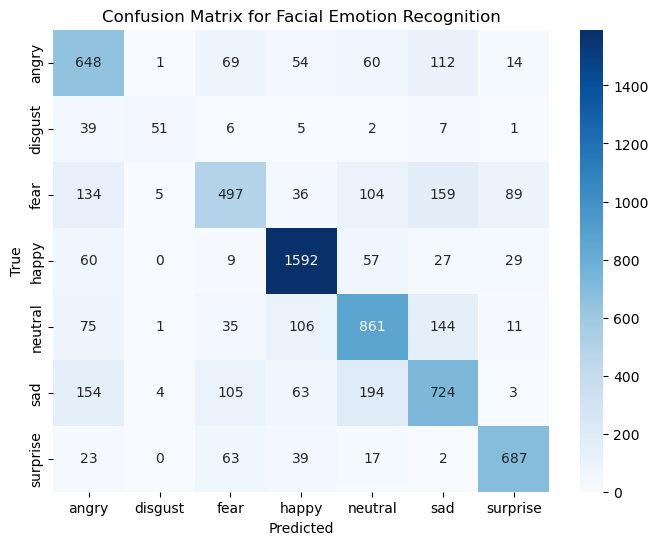

In [88]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Facial Emotion Recognition')
plt.show()


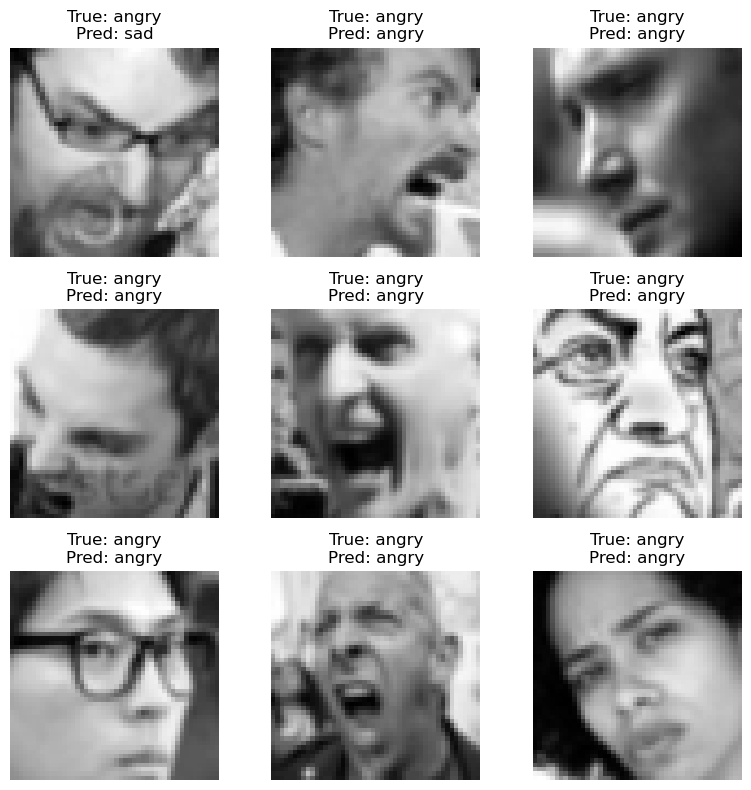

In [89]:
images, labels = next(iter(test_loader))
images, labels = images.to('mps'), labels.to('mps')
outputs = CNN(images)
preds = torch.argmax(outputs, dim=1)
images = images * 0.5 + 0.5
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().squeeze()
    ax.imshow(img, cmap='gray')
    true_label = dataset.classes[labels[i]]
    pred_label = dataset.classes[preds[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis('off')
plt.tight_layout()
plt.show()
